In [2]:
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

[MP2_FaceMask_Dataset.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of MP2_FaceMask_Dataset.zip or
        MP2_FaceMask_Dataset.zip.zip, and cannot find MP2_FaceMask_Dataset.zip.ZIP, period.
Data Downloaded Successfuly!!


In [2]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob, os
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Paths to the dataset directories
dataset_dir = '/kaggle/input/facemaskdataset/MP2_FaceMask_Dataset/train'
classes = ['with_mask', 'without_mask', 'partial_mask']

# Initialize lists to store image shapes and class distribution
image_shapes = []
class_distribution = {class_name: 0 for class_name in classes}

# Iterate through each class directory
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        # Open image and get its shape
        with Image.open(img_path) as img:
            image_shapes.append(img.size)
        # Increment the class count
        class_distribution[class_name] += 1

# Convert image shapes to a numpy array for analysis
image_shapes = np.array(image_shapes)

# Display the first few image shapes
print("Sample image shapes:")
print(image_shapes[:10])

# Display the overall class distribution
print("Class distribution:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count} images")

Sample image shapes:
[[ 356  549]
 [ 160  160]
 [ 160  160]
 [ 160  160]
 [ 160  160]
 [ 160  160]
 [ 320  428]
 [1360 1360]
 [ 160  160]
 [ 160  160]]
Class distribution:
with_mask: 1624 images
without_mask: 2138 images
partial_mask: 1294 images


In [4]:
TRAINING_DIR = "/kaggle/input/facemaskdataset/MP2_FaceMask_Dataset/train"
VALIDATION_DIR = "/kaggle/input/facemaskdataset/MP2_FaceMask_Dataset/test"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load data using the generator
train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

test_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 4025 images belonging to 3 classes.
Found 1009 images belonging to 3 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')  # Assuming 3 classes: masked, unmasked, partially masked
])

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,195 (3.42 MB)

 Trainable params: 896,195 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Define data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
test_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=5
)
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(test_generator)
print(f'Validation accuracy: {val_acc}')

Found 4025 images belonging to 3 classes.
Found 250 images belonging to 3 classes.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.4705 - loss: 1.1030 

I0000 00:00:1718522829.614989     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718522829.632904     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8024 - loss: 0.4775

W0000 00:00:1718522849.248600     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.8032 - loss: 0.4759 - val_accuracy: 0.9241 - val_loss: 0.2150
Epoch 2/5
  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8750 - loss: 0.2181

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8750 - loss: 0.2181 - val_accuracy: 0.8846 - val_loss: 0.4639
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.9576 - loss: 0.1302 - val_accuracy: 0.9330 - val_loss: 0.1761
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.9062 - loss: 0.1724 - val_accuracy: 0.9231 - val_loss: 0.2211
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.9729 - loss: 0.0915 - val_accuracy: 0.9286 - val_loss: 0.3656
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9371 - loss: 0.2561
Validation accuracy: 0.9279999732971191


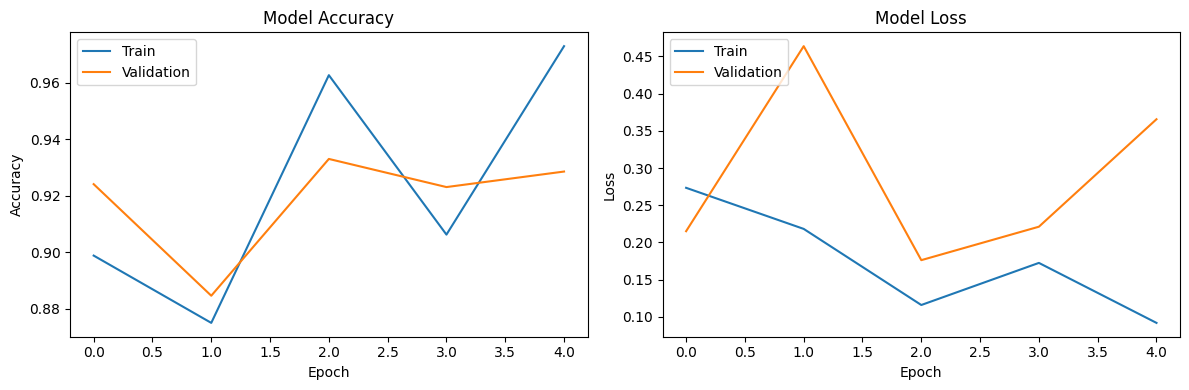

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Use the pre-trained models (VGG16)

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set up data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
# Load the VGG16 model with pre-trained ImageNet weights, exclude the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Print model summary
model.summary()

Found 4025 images belonging to 3 classes.
Found 250 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,779 (60.13 MB)

 Trainable params: 1,049,091 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10
)
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(test_generator)
print(f'Validation accuracy: {val_acc}')

# Unfreeze some of the top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Re-train the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10
)
# Evaluate the fine-tuned model on validation data
val_loss_fine, val_acc_fine = model.evaluate(test_generator)
print(f'Validation accuracy after fine-tuning: {val_acc_fine}')

Epoch 1/10
  3/125 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.3264 - loss: 1.7844  

W0000 00:00:1718522953.169867     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8193 - loss: 0.4993

W0000 00:00:1718522979.117205     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718522980.382078     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 225ms/step - accuracy: 0.8201 - loss: 0.4974 - val_accuracy: 0.9732 - val_loss: 0.0782
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9375 - loss: 0.1275 - val_accuracy: 1.0000 - val_loss: 0.0255
Epoch 3/10


W0000 00:00:1718522992.246480      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.9730 - loss: 0.0775 - val_accuracy: 0.9866 - val_loss: 0.0437
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.9688 - loss: 0.0480 - val_accuracy: 0.9615 - val_loss: 0.1679
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9842 - loss: 0.0477 - val_accuracy: 0.9821 - val_loss: 0.0525
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 1.0000 - loss: 0.0515 - val_accuracy: 1.0000 - val_loss: 0.0495
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9857 - loss: 0.0400 - val_accuracy: 0.9821 - val_loss: 0.0540
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.9914 - loss: 0.0278 - val_accuracy: 0.9911 - val_loss: 0.0243
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 1.0000 - loss: 0.0032 - val_ac

W0000 00:00:1718523063.057276     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9905 - loss: 0.0235

W0000 00:00:1718523079.279355     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9907 - loss: 0.0232

W0000 00:00:1718523081.117582      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9907 - loss: 0.0231 - val_accuracy: 0.9911 - val_loss: 0.0243
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9615 - val_loss: 0.1560
Epoch 3/10


W0000 00:00:1718523082.245048     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9967 - loss: 0.0103 - val_accuracy: 0.9866 - val_loss: 0.0252
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.9688 - loss: 0.0321 - val_accuracy: 1.0000 - val_loss: 6.4478e-05
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9996 - loss: 0.0046 - val_accuracy: 0.9911 - val_loss: 0.0201
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 1.0000 - loss: 2.6184e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.9866 - val_loss: 0.0261
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 1.0000 - loss: 4.1148e-04 - val_accuracy: 1.0000 - val_loss: 7.6933e-04
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9866 - val_loss: 0.0348
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 1.0000 - loss:

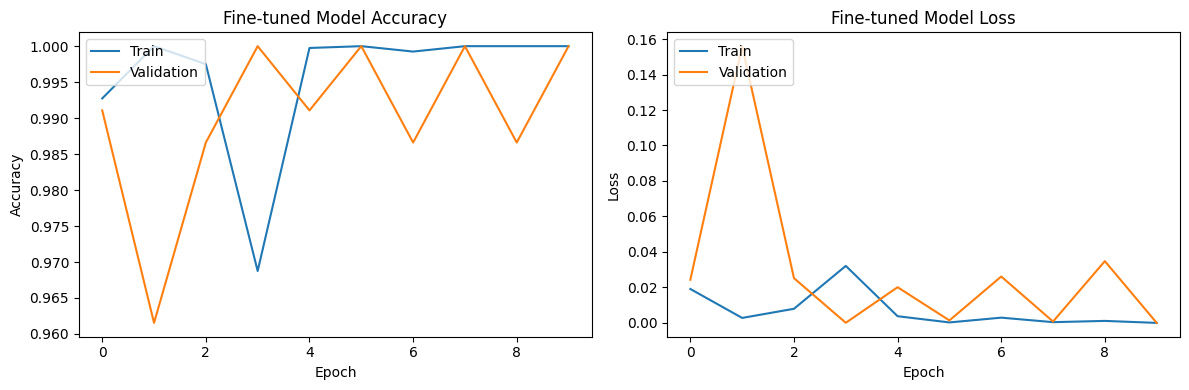

In [11]:
# Plot training history of fine-tuning
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Fine-tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Fine-tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Kaggle competition predictions 

In [44]:
import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf

# Specify the directory containing the test images and the sample submission file
image_directory = '/kaggle/input/cds-b7-face-mask-detection/FaceMask_Kaggle_test'  # Replace with your actual path
sample_submission_path = '/kaggle/input/cds-b7-face-mask-detection/Sample_Submission.csv'  # Replace with your actual path

# Desired shape for resizing (Replace with your model's input size)
resize_shape = (128, 128)

# Use glob to get all image file paths in the directory
image_paths = glob.glob(f'{image_directory}/**/*', recursive=True)

# Filter out directories from the list of paths
image_paths = [path for path in image_paths if os.path.isfile(path)]

# Print the number of images found
print(f"Number of images found: {len(image_paths)}")

# Loop through image paths, open, resize, and store the images and paths
resized_images = []
image_paths_resized = []

for path in image_paths:
    with Image.open(path) as img:
        img_resized = img.resize(resize_shape)
        resized_images.append(np.array(img_resized))
        image_paths_resized.append(path)

# Convert the list of images to a numpy array
resized_images_array = np.array(resized_images)

# Print the shape of the resized images array
print(f"Shape of resized images array: {resized_images_array.shape}")

# Normalize the images if required by the model (e.g., rescale pixel values to [0, 1])
resized_images_array = resized_images_array / 255.0

# Get predictions from the model
predictions = model.predict(resized_images_array)

# Print the predictions to check if they have values
print(f"Predictions shape: {predictions.shape}")
print(predictions)

# Get the class with the maximum value for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted classes to verify
print(f"Predicted classes: {predicted_classes}")

# Decode the predicted classes to their corresponding labels
class_labels = {0: 'with_mask', 1: 'partial_mask', 2: 'without_mask'}  # Example mapping, replace with your actual mapping
decoded_predictions = [class_labels.get(pred, "unknown") for pred in predicted_classes]

# Print the decoded predictions to verify
print(f"Decoded predictions: {decoded_predictions}")

# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    'img_path': image_paths_resized,
    'label': decoded_predictions
})
# Read the sample submission file to ensure the order of the predictions
sample_submission_df = pd.read_csv(sample_submission_path)

# Ensure predictions are in the same order as sample submission
submission_df = submission_df.set_index('img_path').reindex(sample_submission_df['img_path']).reset_index()

# Save the predictions to a CSV file
submission_df.to_csv('preds.csv', index=False)

Number of images found: 660
Shape of resized images array: (660, 128, 128, 3)
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Predictions shape: (660, 3)
[[3.1622886e-07 3.3674060e-06 9.9999630e-01]
 [9.9997890e-01 2.1087430e-05 5.9274400e-15]
 [7.5437913e-07 9.9157977e-01 8.4195826e-03]
 ...
 [9.9999917e-01 8.5196911e-07 4.1968490e-13]
 [1.2013749e-05 2.0575360e-08 9.9998796e-01]
 [2.4877743e-05 3.0242218e-04 9.9967271e-01]]
Predicted classes: [2 0 1 2 2 2 2 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 0 2 2 0 0
 0 0 2 2 0 0 0 0 0 0 0 0 1 0 0 2 0 2 2 2 2 0 0 0 0 2 0 2 0 2 0 2 2 0 0 2 2
 2 2 2 0 0 0 0 0 0 2 0 0 0 1 0 0 2 2 0 0 0 0 0 2 0 2 2 0 0 0 0 0 1 0 2 2 0
 1 2 0 0 1 0 0 0 2 0 0 2 0 1 2 2 1 2 0 2 0 2 0 0 0 2 2 0 0 0 0 0 0 1 2 0 0
 2 0 0 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 2 2 0 0 0 1 0 0 0 2 2 1 2 2 0 0 0 0
 0 0 2 0 0 2 0 0 2 2 0 0 2 0 0 1 2 1 0 0 1 2 1 2 0 1 2 0 0 0 0 0 0 0 0 0 2
 0 1 2 2 2 0 2 2 2 2 2 1 0 0 2 0 2 2 0 2 2 1 0 2 1 0 0 0 0 2 0 1 2 0 2 0 0
 2 2 0 2 0 0 0 2 2 0 0 0 0 0 2 2 2